## Installing all the required packages and libraries

In [1]:
!pip uninstall -qqy jupyterlab  # Remove unused conflicting packages
!pip install -U -q "google-genai==1.7.0"

from google import genai
from google.genai import types

genai.__version__

'1.7.0'

In [2]:
import numpy as np
import pandas as pd
import os
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import io
import base64
import json

In [3]:
!pip install python-dotenv


## Loading the datasets

In [4]:
from dotenv import load_dotenv
import os
from google import genai

load_dotenv(dotenv_path="/Users/deva/DEVA/F1_AI_Agent/Google_API_Key.env")

#Save the path of the Google API key or any other LLM model that you want to use in the .env file format


True

## Adding the Google API Key

In [5]:
# Get API key securely
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
if not GOOGLE_API_KEY:
    raise ValueError("API key not found! Please add it to your .env file.")

# Create client with your API key (no configure method in v1.7.0)
client = genai.Client(api_key=GOOGLE_API_KEY)

print("SDK Version:", genai.__version__)

SDK Version: 1.7.0


## Handling API rate limits automatically.

In [6]:
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

## Creating a database & importing files

In [7]:
import sqlite3
import pandas as pd
import os

# Change this path to where your dataset files are stored locally
input_folder = '/Users/deva/DEVA/F1_AI_Agent/Data'

# Create/connect to the SQLite database file locally
db_path = 'F1_DB.sqlite'  # you can also give a full path here
conn = sqlite3.connect(db_path)

# List of CSV files you want to import
csv_files = [
    'circuits.csv',
    'constructors.csv',
    'constructor_results.csv',
    'constructor_standings.csv',
    'drivers.csv',
    'driver_standings.csv',
    'lap_times.csv',
    'pit_stops.csv',
    'qualifying.csv',
    'races.csv',
    'results.csv',
    'seasons.csv',
    'status.csv'
]

for csv_file in csv_files:
    file_path = os.path.join(input_folder, csv_file)
    if os.path.exists(file_path):
        # Read CSV into pandas DataFrame
        df = pd.read_csv(file_path)
        # Write the DataFrame to the SQL table with the same name as the CSV (without .csv)
        table_name = os.path.splitext(csv_file)[0]
        df.to_sql(table_name, conn, if_exists='replace', index=False)
        print(f"Imported {csv_file} into table {table_name}")
    else:
        print(f"File not found: {file_path}")

# Close the DB connection when done
conn.close()



Imported circuits.csv into table circuits
Imported constructors.csv into table constructors
Imported constructor_results.csv into table constructor_results
Imported constructor_standings.csv into table constructor_standings
Imported drivers.csv into table drivers
Imported driver_standings.csv into table driver_standings
Imported lap_times.csv into table lap_times
Imported pit_stops.csv into table pit_stops
Imported qualifying.csv into table qualifying
Imported races.csv into table races
Imported results.csv into table results
Imported seasons.csv into table seasons
Imported status.csv into table status


In [8]:
os.listdir(input_folder)


['circuits.csv',
 'status.csv',
 'lap_times.csv',
 'sprint_results.csv',
 'drivers.csv',
 'races.csv',
 'constructors.csv',
 'constructor_standings.csv',
 'qualifying.csv',
 'driver_standings.csv',
 'constructor_results.csv',
 'pit_stops.csv',
 'seasons.csv',
 'results.csv']

## Creating Tables from the .CSV Files

In [9]:
db_conn = sqlite3.connect('F1_DB.sqlite')  # <-- You forgot this line in your code

# Loop through all CSV files in the folder
for filename in os.listdir(input_folder):
    if filename.endswith('.csv'):  # For every CSV file
        file_path = os.path.join(input_folder, filename)  # Full path to the CSV file
        df = pd.read_csv(file_path)  # Load the CSV into a DataFrame
        table_name = os.path.splitext(filename)[0]  # Use the filename (without .csv) as the table name
        df.to_sql(table_name, db_conn, if_exists='replace', index=False)  # Insert into SQLite DB
        print(f"Imported {filename} into DB as table '{table_name}'")

# Close the database connection
db_conn.close()

Imported circuits.csv into DB as table 'circuits'
Imported status.csv into DB as table 'status'
Imported lap_times.csv into DB as table 'lap_times'
Imported sprint_results.csv into DB as table 'sprint_results'
Imported drivers.csv into DB as table 'drivers'
Imported races.csv into DB as table 'races'
Imported constructors.csv into DB as table 'constructors'
Imported constructor_standings.csv into DB as table 'constructor_standings'
Imported qualifying.csv into DB as table 'qualifying'
Imported driver_standings.csv into DB as table 'driver_standings'
Imported constructor_results.csv into DB as table 'constructor_results'
Imported pit_stops.csv into DB as table 'pit_stops'
Imported seasons.csv into DB as table 'seasons'
Imported results.csv into DB as table 'results'


## Verifying if everything is imported correctly

In [10]:
db_conn = sqlite3.connect('F1_DB.sqlite')

# Fetch all table names
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", db_conn)
print("List of imported tables:\n", tables)

# Loop through each table and display the first 5 rows
for table in tables['name']:
    print(f"\nPreview of table: {table}")
    df = pd.read_sql_query(f"SELECT * FROM {table} LIMIT 5;", db_conn)
    print(df)

# Close the database connection
db_conn.close()

List of imported tables:
                      name
0                circuits
1                  status
2               lap_times
3          sprint_results
4                 drivers
5                   races
6            constructors
7   constructor_standings
8              qualifying
9        driver_standings
10    constructor_results
11              pit_stops
12                seasons
13                results

Preview of table: circuits
   circuitId   circuitRef                            name      location  \
0          1  albert_park  Albert Park Grand Prix Circuit     Melbourne   
1          2       sepang    Sepang International Circuit  Kuala Lumpur   
2          3      bahrain   Bahrain International Circuit        Sakhir   
3          4    catalunya  Circuit de Barcelona-Catalunya      Montmeló   
4          5     istanbul                   Istanbul Park      Istanbul   

     country       lat        lng  alt  \
0  Australia -37.84970  144.96800   10   
1   Malaysia   2.7608

## Create DB interaction tools for the LLM including plotting

In [11]:
db_conn = sqlite3.connect('F1_DB.sqlite')

def list_tables() -> list[str]:
    """Retrieve the names of all tables in the database."""
    print(' - DB CALL: list_tables()')

    cursor = db_conn.cursor()

    # Fetch the table names
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()

    # Return the list of table names
    return [t[0] for t in tables]

# Call the function
tables = list_tables()
print("Tables in the database:", tables)

# Close the connection
db_conn.close()

 - DB CALL: list_tables()
Tables in the database: ['circuits', 'status', 'lap_times', 'sprint_results', 'drivers', 'races', 'constructors', 'constructor_standings', 'qualifying', 'driver_standings', 'constructor_results', 'pit_stops', 'seasons', 'results']


## Similarly Let's list the columns of every table

In [12]:
db_conn = sqlite3.connect('F1_DB.sqlite')

def describe_table(table_name: str) -> list[tuple[str, str]]:
    """Look up the table schema.

    Returns:
      List of columns, where each entry is a tuple of (column, type).
    """
    print(f' - DB CALL: describe_table({table_name})')

    cursor = db_conn.cursor()

    cursor.execute(f"PRAGMA table_info({table_name});")

    schema = cursor.fetchall()
    # [column index, column name, column type, ...]
    return [(col[1], col[2]) for col in schema]


columns = describe_table('circuits')
print(f"Schema for 'circuits': {columns}")

db_conn.close()

 - DB CALL: describe_table(circuits)
Schema for 'circuits': [('circuitId', 'INTEGER'), ('circuitRef', 'TEXT'), ('name', 'TEXT'), ('location', 'TEXT'), ('country', 'TEXT'), ('lat', 'REAL'), ('lng', 'REAL'), ('alt', 'INTEGER'), ('url', 'TEXT')]


## To run a SELECT query to extract data from the DB

In [13]:
db_conn = sqlite3.connect('F1_DB.sqlite')

def execute_query(sql: str) -> list[list[str]]:
    """Execute an SQL statement, returning the results"""
    print(f' - DB CALL: execute_query({sql})')

    cursor = db_conn.cursor()
    cursor.execute(sql)
    return cursor.fetchall()

# Example usage
results = execute_query("SELECT name FROM circuits")

print("Query results:")
for row in results:
    print(row[0])  # Print each name on a new line

# Close the connection
db_conn.close()

 - DB CALL: execute_query(SELECT name FROM circuits)
Query results:
Albert Park Grand Prix Circuit
Sepang International Circuit
Bahrain International Circuit
Circuit de Barcelona-Catalunya
Istanbul Park
Circuit de Monaco
Circuit Gilles Villeneuve
Circuit de Nevers Magny-Cours
Silverstone Circuit
Hockenheimring
Hungaroring
Valencia Street Circuit
Circuit de Spa-Francorchamps
Autodromo Nazionale di Monza
Marina Bay Street Circuit
Fuji Speedway
Shanghai International Circuit
Autódromo José Carlos Pace
Indianapolis Motor Speedway
Nürburgring
Autodromo Enzo e Dino Ferrari
Suzuka Circuit
Las Vegas Strip Street Circuit
Yas Marina Circuit
Autódromo Juan y Oscar Gálvez
Circuito de Jerez
Autódromo do Estoril
Okayama International Circuit
Adelaide Street Circuit
Kyalami
Donington Park
Autódromo Hermanos Rodríguez
Phoenix street circuit
Circuit Paul Ricard
Korean International Circuit
Autódromo Internacional Nelson Piquet
Detroit Street Circuit
Brands Hatch
Circuit Park Zandvoort
Zolder
Dijon-Pren

## Let's define a function that takes a query and returns the results as pd.Dataframe

In [14]:
db_conn = sqlite3.connect('F1_DB.sqlite')

def execute_query_df(sql: str) -> pd.DataFrame:
    """Execute an SQL SELECT statement and return the result as a DataFrame."""
    print(f' - DB CALL: execute_query({sql})')

    cursor = db_conn.cursor()
    cursor.execute(sql)

    # Get column names from cursor.description
    columns = [desc[0] for desc in cursor.description]
    rows = cursor.fetchall()

    return pd.DataFrame(rows, columns=columns)

db_conn.close()

# MODULE - 1 Analysis

## Implement the plotting function that takes the query and using the function above transforms it into a bar plot given X and Y column names.

In [15]:
db_conn = sqlite3.connect('F1_DB.sqlite')

def plot_data(query: str, x: str, y: str, kind: str) -> str:
    data = execute_query_df(query)

    plt.figure(figsize=(10, 5))

    if kind == "bar":
        plt.bar(data[x], data[y])
    elif kind == "line":
        plt.plot(data[x], data[y])
    elif kind == "scatter":
        plt.scatter(data[x], data[y])

    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f"{y} vs {x}")

    # Save image to buffer
    buf = io.BytesIO()
    plt.tight_layout()
    plt.savefig(buf, format="png")
    

db_conn.close()

## Implementing the agent

In [16]:
db_conn = sqlite3.connect('F1_DB.sqlite')

# These are the Python functions defined above.
db_tools = [list_tables, describe_table, execute_query, plot_data]

instruction = """You are a helpful chatbot that can interact with an SQL database
which contains data about F1 championships between 1950 and 2024 to answer user questions about it. 
You will take the user's questions and turn them into SQL queries or plot the data or both 
using the tools available. Once you have the information 
you need, you will answer the user's question using the plots and data returned.

For data analysis use list_tables to see what tables are present, describe_table to understand the
schema, and execute_query to issue an SQL SELECT query. 
For plotting use plot_data to generate charts providing it with a SQL SELECT query, 
the name of the column for the X-axis, and the column for the Y-axis.
"""

client = genai.Client(api_key=GOOGLE_API_KEY)

# Start a chat with automatic function calling enabled.
chat = client.chats.create(
    model="gemini-2.0-flash",
    config=types.GenerateContentConfig(
        system_instruction=instruction,
        tools=db_tools,
        temperature=0.0,
    ),
)

db_conn.close()

## Test with some queries

### Test 1

 - DB CALL: execute_query(SELECT driver_name, COUNT(*) AS wins FROM results GROUP BY driver_name ORDER BY wins DESC LIMIT 10)
 - DB CALL: describe_table(results)
 - DB CALL: execute_query(SELECT d.driverRef, COUNT(r.driverId) AS wins FROM results r JOIN drivers d ON r.driverId = d.driverId WHERE r.positionOrder = 1 GROUP BY r.driverId ORDER BY wins DESC LIMIT 10)
 - DB CALL: execute_query(SELECT d.driverRef, d.nationality FROM drivers d WHERE d.driverRef IN ('hamilton', 'michael_schumacher', 'max_verstappen', 'vettel', 'prost', 'senna', 'alonso', 'mansell', 'stewart', 'clark'))
 - DB CALL: execute_query(SELECT d.nationality, COUNT(r.driverId) AS wins FROM results r JOIN drivers d ON r.driverId = d.driverId WHERE r.positionOrder = 1 AND d.driverRef IN ('hamilton', 'michael_schumacher', 'max_verstappen', 'vettel', 'prost', 'senna', 'alonso', 'mansell', 'stewart', 'clark') GROUP BY d.nationality)
 - DB CALL: execute_query(SELECT d.nationality, COUNT(r.driverId) AS wins FROM results r JOIN

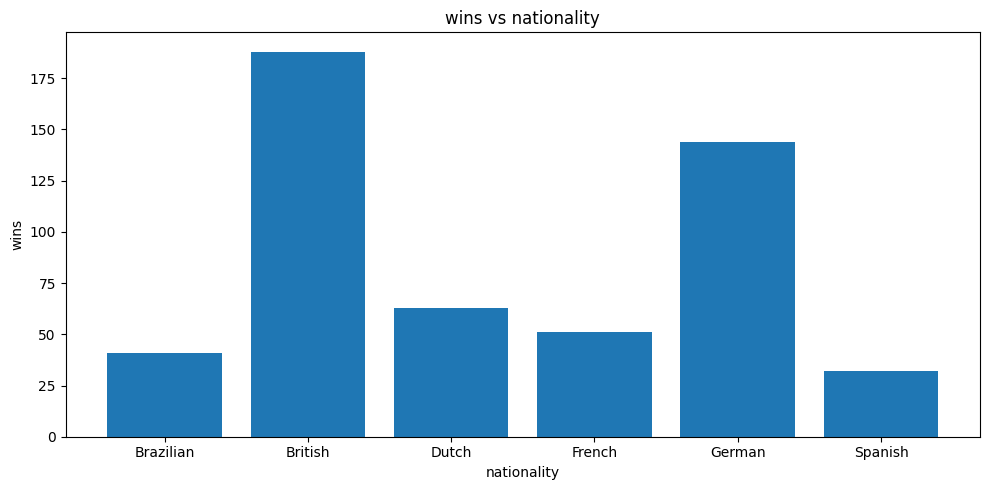

In [17]:
db_conn = sqlite3.connect('F1_DB.sqlite')

resp = chat.send_message("Who are the top-10 F1 drivers with the most race wins? What is their nationality distribution? Can you plot this distribution for wins vs nationality?")
print(f"\n{resp.text}")

db_conn.close()

### Test 2

 - DB CALL: execute_query(SELECT DISTINCT d.driverRef, c.name FROM results r JOIN drivers d ON r.driverId = d.driverId JOIN constructors c ON r.constructorId = c.constructorId WHERE d.driverRef IN ('hamilton', 'michael_schumacher', 'max_verstappen', 'vettel', 'prost', 'senna', 'alonso', 'mansell', 'stewart', 'clark'))
 - DB CALL: execute_query(SELECT c.name, COUNT(r.raceId) AS races FROM results r JOIN drivers d ON r.driverId = d.driverId JOIN constructors c ON r.constructorId = c.constructorId WHERE d.driverRef IN ('hamilton', 'michael_schumacher', 'max_verstappen', 'vettel', 'prost', 'senna', 'alonso', 'mansell', 'stewart', 'clark') GROUP BY c.name ORDER BY races DESC)
 - DB CALL: execute_query(SELECT c.name, COUNT(r.raceId) AS races FROM results r JOIN drivers d ON r.driverId = d.driverId JOIN constructors c ON r.constructorId = c.constructorId WHERE d.driverRef IN ('hamilton', 'michael_schumacher', 'max_verstappen', 'vettel', 'prost', 'senna', 'alonso', 'mansell', 'stewart', 'clark

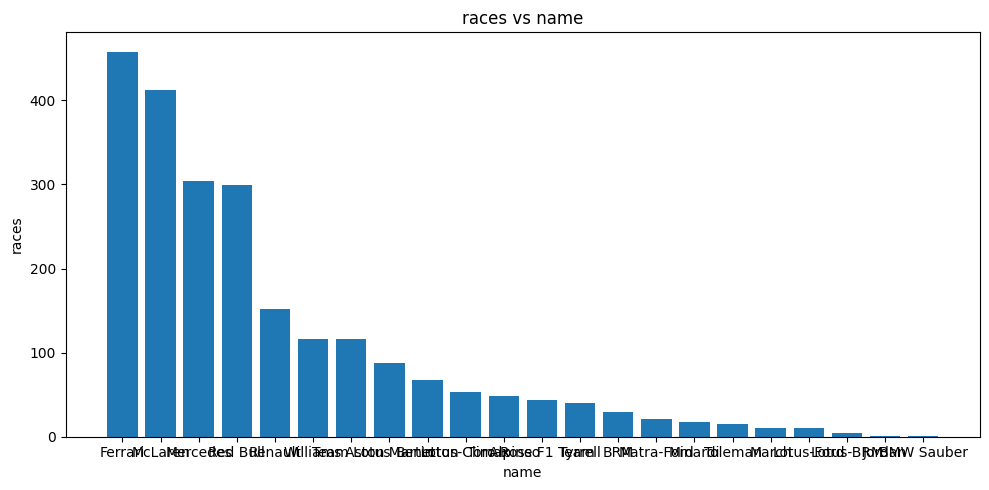

In [18]:
db_conn = sqlite3.connect('F1_DB.sqlite')

resp = chat.send_message("Limiting ourselves to the drivers above what were the contructors they drove for? Can you plot the distribution of constructors again?")
print(f"\n{resp.text}")

db_conn.close()

## Approach using an agent with search capabilities and grounding

In [19]:
db_conn = sqlite3.connect('F1_DB.sqlite')

from IPython.display import display, Image, Markdown

def show_response(response):
    for p in response.candidates[0].content.parts:
        if p.text:
            display(Markdown(p.text))
        elif p.inline_data:
            display(Image(p.inline_data.data))
        else:
            print(p.to_json_dict())
    
        display(Markdown('----'))

db_conn.close()

### Test 3

### To start with attempt to get the information without the agent having any grounding.

In [20]:
db_conn = sqlite3.connect('F1_DB.sqlite')

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents="What is the top-10 of F1 drivers with the most race wins and their nationality distribution?",
)

show_response(response)

db_conn.close()

Okay, here's the top 10 F1 drivers with the most race wins, along with their nationality distribution:

**Top 10 F1 Drivers by Race Wins:**

| Rank | Driver           | Nationality | Wins |
|------|------------------|-------------|------|
| 1    | Lewis Hamilton     | British     | 103  |
| 2    | Michael Schumacher | German      | 91   |
| 3    | Max Verstappen   | Dutch       | 61   |
| 4    | Sebastian Vettel  | German      | 53   |
| 5    | Alain Prost        | French      | 51   |
| 6    | Ayrton Senna       | Brazilian   | 41   |
| 7    | Fernando Alonso    | Spanish     | 32   |
| 8    | Nigel Mansell      | British     | 31   |
| 9    | Jackie Stewart     | British     | 27   |
| 10   | Jim Clark          | British     | 25   |

**Nationality Distribution:**

*   **British:** 4 (Lewis Hamilton, Nigel Mansell, Jackie Stewart, Jim Clark)
*   **German:** 2 (Michael Schumacher, Sebastian Vettel)
*   **Dutch:** 1 (Max Verstappen)
*   **French:** 1 (Alain Prost)
*   **Brazilian:** 1 (Ayrton Senna)
*   **Spanish:** 1 (Fernando Alonso)

----

### The above is missing some recent data, that the agent does not have access to. Try again with google search grounding to get the latest information (note change of wins)

In [21]:
db_conn = sqlite3.connect('F1_DB.sqlite')

config_with_search = types.GenerateContentConfig(
    tools = [types.Tool(google_search=types.GoogleSearch())],
    temperature = 0.0,
)

chat = client.chats.create(model='gemini-2.0-flash')

response = chat.send_message(
    message="What is the top-10 of F1 drivers with the most race wins and i want their nationality distribution?",
    config=config_with_search,
)

show_response(response)

db_conn.close()

Here is the list of the top 10 F1 drivers with the most race wins in their careers, along with a nationality distribution:

**Top 10 F1 Drivers with the Most Race Wins**

1.  Lewis Hamilton (Great Britain): 105 wins
2.  Michael Schumacher (Germany): 91 wins
3.  Max Verstappen (Netherlands): 65 wins
4.  Sebastian Vettel (Germany): 53 wins
5.  Alain Prost (France): 51 wins
6.  Ayrton Senna (Brazil): 41 wins
7.  Fernando Alonso (Spain): 32 wins
8.  Nigel Mansell (Great Britain): 31 wins
9.  Jackie Stewart (Great Britain): 27 wins
10. Jim Clark (Great Britain): 25 wins

**Nationality Distribution**

*   Great Britain: 4
*   Germany: 2
*   Netherlands: 1
*   France: 1
*   Brazil: 1
*   Spain: 1



----

### TEST 4

## we have the desired information, we can ask it to produce a plot

Okay, I can create those charts for you. Here's the Python code to generate the bar chart of wins per driver and the pie chart of nationality distribution using Seaborn and Matplotlib:



----

{'executable_code': {'code': "import matplotlib.pyplot as plt\nimport seaborn as sns\nimport pandas as pd\n\n# Data\ndriver_wins = {\n    'Lewis Hamilton': 105,\n    'Michael Schumacher': 91,\n    'Max Verstappen': 65,\n    'Sebastian Vettel': 53,\n    'Alain Prost': 51,\n    'Ayrton Senna': 41,\n    'Fernando Alonso': 32,\n    'Nigel Mansell': 31,\n    'Jackie Stewart': 27,\n    'Jim Clark': 25\n}\n\nnationality_counts = {\n    'Great Britain': 4,\n    'Germany': 2,\n    'Netherlands': 1,\n    'France': 1,\n    'Brazil': 1,\n    'Spain': 1\n}\n\n# Create DataFrame for wins per driver\ndf_wins = pd.DataFrame(list(driver_wins.items()), columns=['Driver', 'Wins'])\ndf_wins = df_wins.sort_values('Wins', ascending=False)\n\n# Create DataFrame for nationality distribution\ndf_nationality = pd.DataFrame(list(nationality_counts.items()), columns=['Nationality', 'Count'])\n\n# Bar chart of wins per driver\nplt.figure(figsize=(12, 6))\nsns.barplot(x='Wins', y='Driver', data=df_wins, palette='vi

----

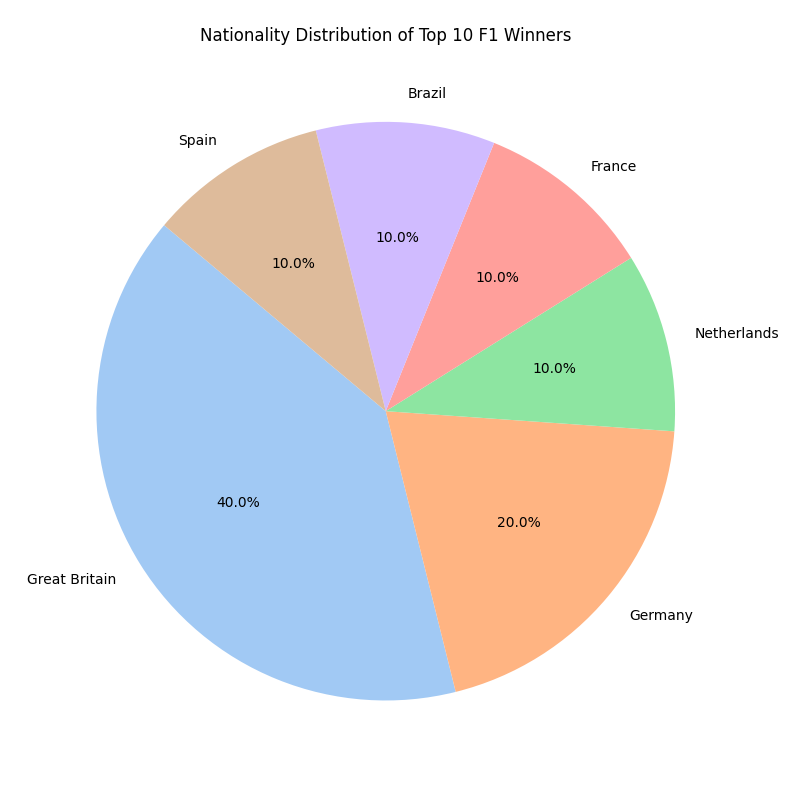

----

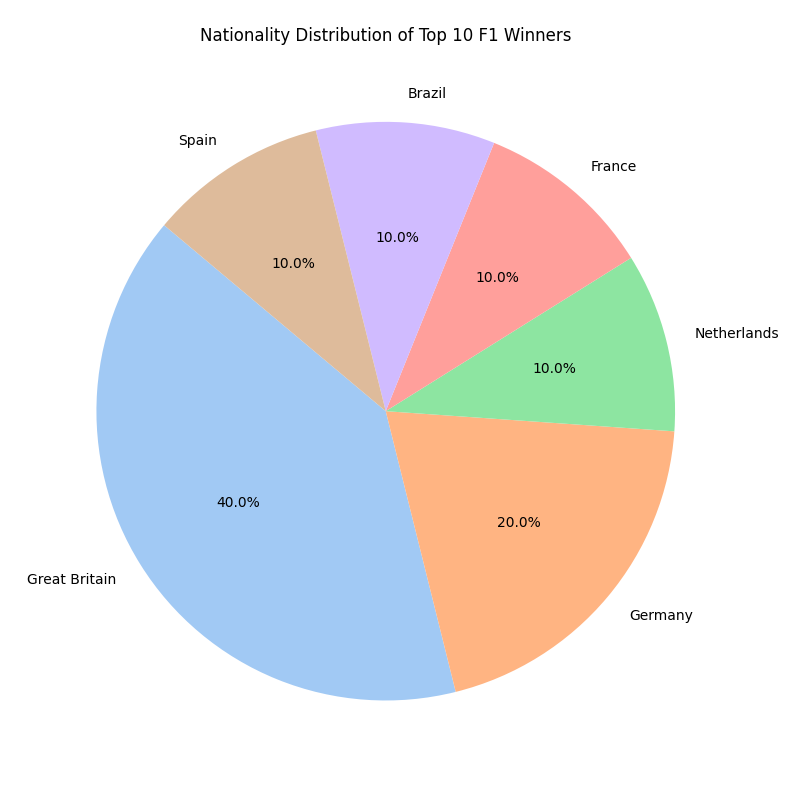

----

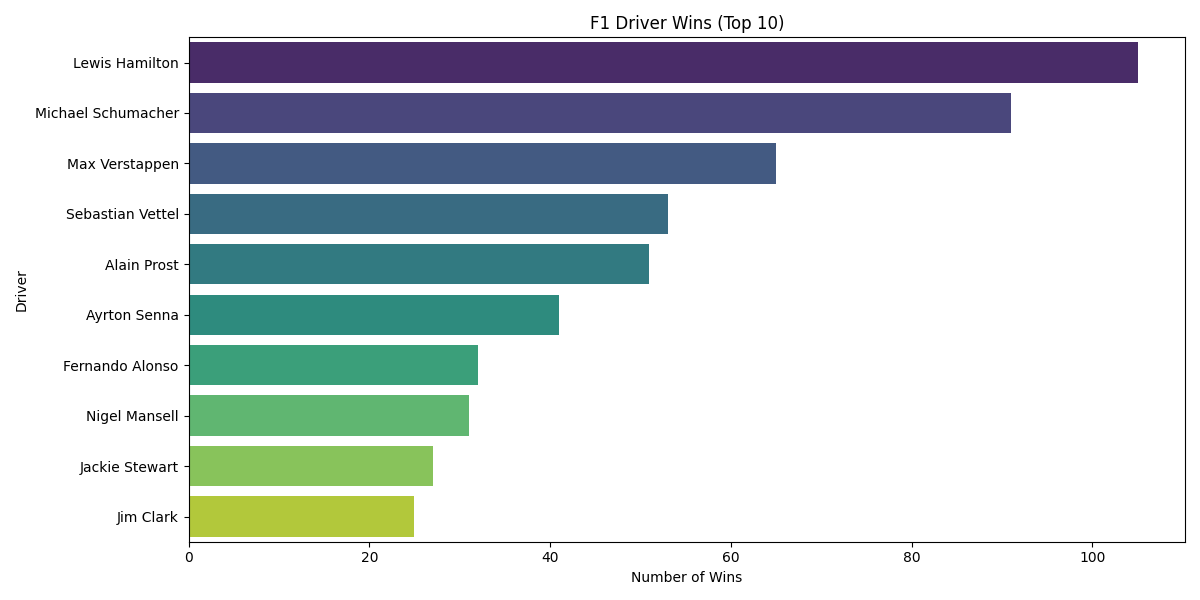

----

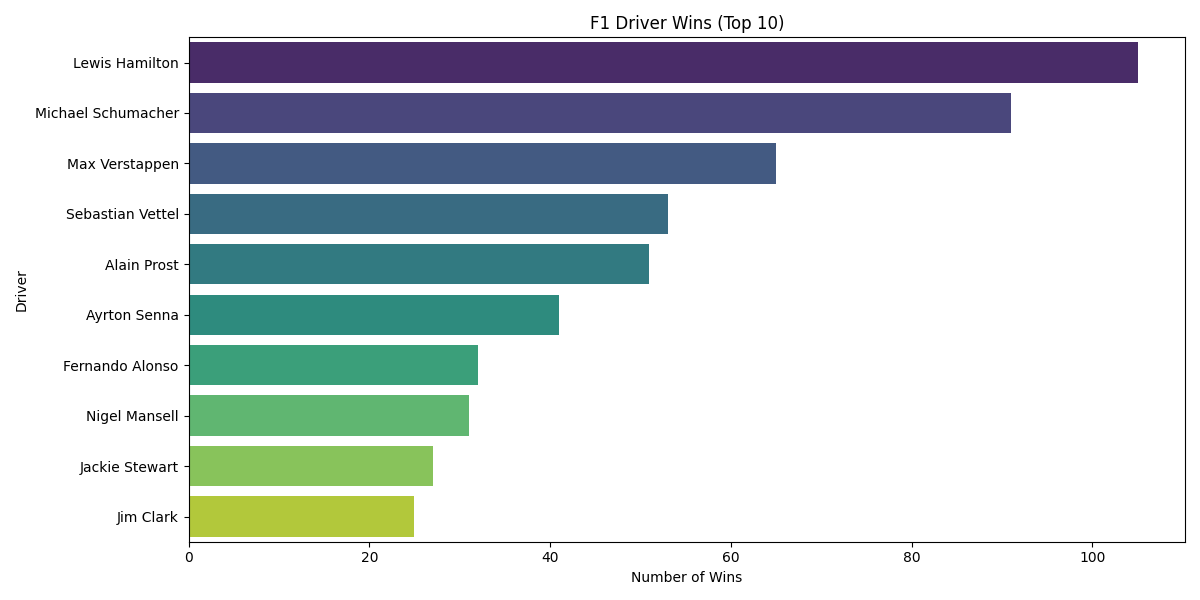

----

The code has generated two charts:

1.  **Bar Chart of F1 Driver Wins (Top 10):** This chart displays the number of wins for each of the top 10 F1 drivers, sorted in descending order. The x-axis represents the number of wins, and the y-axis represents the driver's name.
2.  **Pie Chart of Nationality Distribution:** This chart shows the distribution of nationalities among the top 10 F1 drivers. Each slice of the pie represents a nationality, and the size of the slice corresponds to the proportion of drivers from that nationality.

Both charts have been saved as PNG files (`driver_wins_bar.png` and `nationality_pie.png`).


----

In [22]:
db_conn = sqlite3.connect('F1_DB.sqlite')

config_with_code = types.GenerateContentConfig(
    tools = [types.Tool(code_execution=types.ToolCodeExecution())],
    temperature = 0,
)

response = chat.send_message(
    message= "Now plot this as a seaborn chart. Also create a bar chart showing the number of wins for each driver, and then a pie chart showing the nationality distribution.",
    config=config_with_code,
)

show_response(response)

db_conn.close()

## Test 5

/var/folders/0m/h9z_23v10pj2hclcsszt6v2c0000gn/T/ipykernel_15606/1306852281.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lap_times_australia_2024['lap_time_seconds'] = lap_times_australia_2024['milliseconds'] / 1000


Average Lap Time: 84.54 seconds


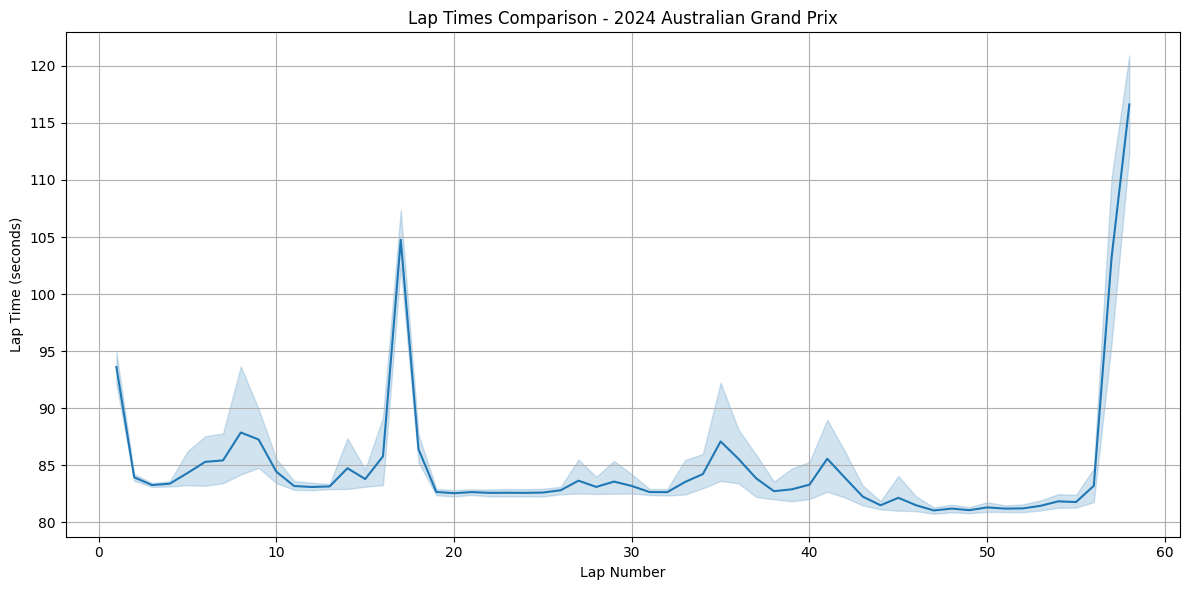

In [24]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to the database
with sqlite3.connect('F1_DB.sqlite') as conn:
    # Load races and lap_times directly from the DB
    races = pd.read_sql_query("SELECT * FROM races", conn)
    lap_times = pd.read_sql_query("SELECT * FROM lap_times", conn)

# Filter for the 2024 Australian Grand Prix
australian_gp_2024 = races[(races['year'] == 2024) & (races['name'].str.contains('Australian Grand Prix'))]

if len(australian_gp_2024) == 0:
    print("Could not find the 2024 Australian Grand Prix in the races data.")
else:
    race_id = australian_gp_2024['raceId'].values[0]

    lap_times_australia_2024 = lap_times[lap_times['raceId'] == race_id]

    # Convert milliseconds to seconds
    lap_times_australia_2024['lap_time_seconds'] = lap_times_australia_2024['milliseconds'] / 1000

    # Calculate the average lap time
    average_lap_time = lap_times_australia_2024['lap_time_seconds'].mean()
    print(f"Average Lap Time: {average_lap_time:.2f} seconds")

    # Create the plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='lap', y='lap_time_seconds', data=lap_times_australia_2024)
    plt.title('Lap Times Comparison - 2024 Australian Grand Prix')
    plt.xlabel('Lap Number')
    plt.ylabel('Lap Time (seconds)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
db_conn.close()

# MODULE - 2 PREDICTIONS

In [25]:
db_conn = sqlite3.connect('F1_DB.sqlite')

config_with_code = types.GenerateContentConfig(
    tools = [types.Tool(code_execution=types.ToolCodeExecution())],
    temperature = 0,
)

response = chat.send_message(
    message= "Predict the next 2026 Hungarian Grand Prix winner",
    config=config_with_code,
)

show_response(response)

db_conn.close()

Predicting the winner of the 2026 Hungarian Grand Prix with certainty is impossible due to the numerous unpredictable factors that influence a Formula 1 race. These factors include:

*   **Driver Skill and Form:** A driver's skill, experience, and current form are crucial.
*   **Car Performance:** The performance and reliability of the car are paramount. This includes engine power, aerodynamics, and handling.
*   **Team Strategy:** Pit stop strategy, tire management, and race tactics play a significant role.
*   **Weather Conditions:** Rain or extreme heat can dramatically alter the race outcome.
*   **Mechanical Failures:** Unexpected mechanical issues can sideline even the most competitive drivers.
*   **Accidents and Safety Cars:** Accidents can lead to safety car periods, which can bunch up the field and change the race dynamics.
*   **Rule Changes:** The 2026 season will see new engine regulations, which could significantly shake up the competitive order.

However, I can offer a *speculative* prediction based on current trends and potential future developments:

**Factors Favoring Max Verstappen:**

*   **Dominant Form:** Max Verstappen and Red Bull Racing have been the dominant force in recent years. If Red Bull can adapt well to the 2026 regulations, Verstappen would be a strong contender.
*   **Driving Skill:** Verstappen is widely regarded as one of the most talented drivers on the grid.

**Factors Favoring Other Drivers:**

*   **Charles Leclerc (Ferrari):** If Ferrari can provide Leclerc with a consistently competitive car, he has the talent to win.
*   **George Russell (Mercedes):** If Mercedes can return to the front of the grid, Russell has the potential to challenge for wins.
*   **Lando Norris (McLaren):** If McLaren continues its upward trajectory, Norris could be a contender.
*   **New Talents:** A new generation of drivers may emerge by 2026, potentially challenging the established order.

**Therefore, a speculative prediction would be:**

**Max Verstappen** is a likely contender, *assuming* Red Bull adapts well to the 2026 regulations and maintains a competitive car. However, drivers like **Charles Leclerc, George Russell, and Lando Norris** could also be strong contenders if their respective teams improve their performance. A dark horse could be a driver who is not currently considered a top contender but who emerges as a star by 2026.

**Disclaimer:** This is purely a speculative prediction based on current information and potential future developments. The actual outcome of the 2026 Hungarian Grand Prix could be very different.


----